# Kaggle Titanic Competition Deep Neural Network

In [1]:
import pandas as pd
import torch
import numpy as np
import math as m
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt

## CUDA Configuration

In [2]:
# PyTorch Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if not torch.cuda.is_available():
    print("Warning CUDA not Found. Using CPU.")

## Hyperparameters

In [3]:
LR = 0.0005
NUM_BATCHES = 64
EPOCHS = 8000

## Load Data

In [4]:
# Load the datatsets into the program 
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Save Test IDs
test_ids = test["PassengerId"]

# Visualise train data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Preprocessing 

In [5]:
# Remove Unnecessary Columns 
train.drop(["PassengerId", "Name", "Cabin", "Ticket"], axis=1, inplace=True)
test.drop(["PassengerId", "Name", "Cabin", "Ticket"], axis=1, inplace=True)

# Fill Missing Embarked Values
train.fillna({"Embarked": "U"}, inplace=True)
test.fillna({"Embarked": "U"}, inplace=True)

# Fill Missing Age Values with Mean Age
train.fillna({"Age": train.Age.mean()}, inplace=True)
test.fillna({"Age": test.Age.mean()}, inplace=True)

# Handle Categorical Data
train = pd.get_dummies(train, columns=["Pclass", "Sex", "Embarked"], dtype=int)
test = pd.get_dummies(test, columns=["Pclass", "Sex", "Embarked"], dtype=int)

# Normalise Age Range
train["Age"] = train["Age"] / train.Age.max()
test["Age"] = test["Age"] / test.Age.max()

# Normalise Fare Range
train["Fare"] = np.log10(train["Fare"]  + 1)
test["Fare"] = np.log10(test["Fare"] + 1)
train["Fare"] = train["Fare"] / train.Fare.max()
test["Fare"] = test["Fare"] / test.Fare.max()

# Normalise SibSb Range
train["SibSp"] = train["SibSp"] / train.SibSp.max()
test["SibSp"] = test["SibSp"] / test.SibSp.max()

# Normalise Parch Range
train["Parch"] = train["Parch"] / train.Parch.max()
test["Parch"] = test["Parch"] / test.Parch.max()

# Add Extra Embarked_U Column to test data
test["Embarked_U"] = 0

train.head(10)

,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_U
0,0,0.275000,0.125,0.000000,0.338125,0,0,1,0,1,0,0,1,0
1,1,0.475000,0.125,0.000000,0.685892,1,0,0,1,0,1,0,0,0
2,1,0.325000,0.000,0.000000,0.350727,0,0,1,1,0,0,0,1,0
3,1,0.437500,0.125,0.000000,0.639463,1,0,0,1,0,0,0,1,0
4,0,0.437500,0.000,0.000000,0.352955,0,0,1,0,1,0,0,1,0
5,0,0.371239,0.000,0.000000,0.360026,0,0,1,0,1,0,1,0,0
6,0,0.675000,0.000,0.000000,0.635755,1,0,0,0,1,0,0,1,0
7,0,0.025000,0.375,0.166667,0.495832,0,0,1,0,1,0,0,1,0
8,1,0.337500,0.000,0.333333,0.399934,0,0,1,1,0,0,0,1,0
9,1,0.175000,0.125,0.000000,0.550603,0,1,0,1,0,1,0,0,0


## Model Design

In [6]:
class TabularDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]
    
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.sigmoid(self.output(x))
        return x

## Data Preparation

In [7]:
# Split the features and the target (desired prediction)
X = train.drop("Survived", axis=1).values
y = train["Survived"].values

# Create the dataset
dataset = TabularDataset(X, y)

# Define DataLoader
dataloader = DataLoader(dataset, batch_size=NUM_BATCHES, shuffle=True)

## Train the Model

In [8]:
# Initialise the Model
input_dim = X.shape[1]  # Number of features
model = NeuralNetwork(input_dim).to(device)

# Set-Up Loss and Optimier Function 
criterion = nn.BCELoss()  # Use as this is a binary classification task
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [9]:
train_losses = []

# Training Loop
for epoch in range(EPOCHS):

    running_training_loss = 0.0
    total_correct = 0
    total_samples = 0

    for features, targets in dataloader:

        # Move onto the GPU
        features = features.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs.squeeze(), targets)

        # Used to calculate the accuracy of the epoch
        predictions = torch.round(outputs.squeeze())
        total_correct += (predictions == targets).sum().item()
        total_samples += targets.size(0)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Combine this loss with all previous epoch losses
        running_training_loss += loss.item() * features.size(0)

    # The epoch accuracy
    accuracy = total_correct / total_samples

    # This epoch loss is the average of all losses
    average_loss = running_training_loss / len(dataloader.dataset)
    train_losses.append(average_loss)

    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [1/8000], Loss: 0.6817, Accuracy: 0.6274
Epoch [2/8000], Loss: 0.6638, Accuracy: 0.6263
Epoch [3/8000], Loss: 0.6453, Accuracy: 0.6779
Epoch [4/8000], Loss: 0.6239, Accuracy: 0.7318
Epoch [5/8000], Loss: 0.5984, Accuracy: 0.7486
Epoch [6/8000], Loss: 0.5705, Accuracy: 0.8036
Epoch [7/8000], Loss: 0.5425, Accuracy: 0.8092
Epoch [8/8000], Loss: 0.5158, Accuracy: 0.8114
Epoch [9/8000], Loss: 0.4945, Accuracy: 0.8114
Epoch [10/8000], Loss: 0.4786, Accuracy: 0.8137
Epoch [11/8000], Loss: 0.4687, Accuracy: 0.8126
Epoch [12/8000], Loss: 0.4601, Accuracy: 0.8171
Epoch [13/8000], Loss: 0.4552, Accuracy: 0.7980
Epoch [14/8000], Loss: 0.4515, Accuracy: 0.8013
Epoch [15/8000], Loss: 0.4476, Accuracy: 0.8159
Epoch [16/8000], Loss: 0.4471, Accuracy: 0.8036
Epoch [17/8000], Loss: 0.4435, Accuracy: 0.8103
Epoch [18/8000], Loss: 0.4409, Accuracy: 0.8081
Epoch [19/8000], Loss: 0.4400, Accuracy: 0.8103
Epoch [20/8000], Loss: 0.4387, Accuracy: 0.8103
Epoch [21/8000], Loss: 0.4369, Accuracy: 0.8126
E

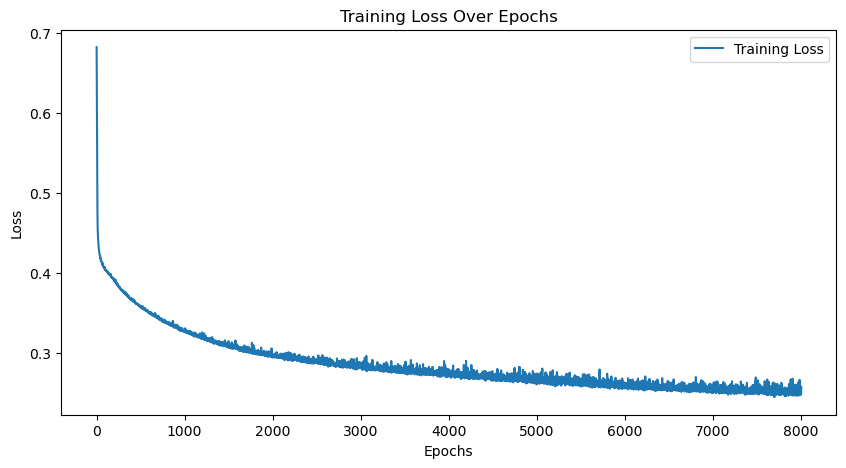

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

## Save Submission

In [22]:
# Convert test data to a tensor
test_features = torch.tensor(test.values, dtype=torch.float32)
test_features = test_features.to(device)

# Set to Evaluation Mode
model.eval()

predictions = []
with torch.no_grad():

    outputs = model(test_features)

    # Convert to binary predictions
    predicted_labels = torch.round(outputs).cpu().numpy()
    predictions.extend(predicted_labels)

# Convert predictions to NumPy array
predictions = np.array(predictions).astype(int)

# Save predictions as CSV file
output = pd.DataFrame({'PassengerId': test_ids.values, 'Survived': predictions.flatten()})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

[[                   0]
 [                   0]
 [                   0]
 [                   0]
 [                   0]
 [                   0]
 [                   1]
 [                   0]
 [                   1]
 [                   0]
 [                   0]
 [                   0]
 [                   1]
 [                   0]
 [                   1]
 [                   1]
 [                   0]
 [                   0]
 [                   0]
 [                   1]
 [                   1]
 [                   1]
 [                   1]
 [                   1]
 [                   1]
 [                   0]
 [                   1]
 [                   0]
 [                   1]
 [                   0]
 [                   0]
 [                   0]
 [                   0]
 [                   0]
 [                   1]
 [                   1]
 [                   0]
 [                   0]
 [                   0]
 [                   1]
 [                   0]
 [              

/tmp/ipykernel_71647/4273220087.py:18: RuntimeWarning: invalid value encountered in cast
  predictions = np.array(predictions).astype(int)
